In [91]:
from urllib.request import urlopen, Request
import pandas_datareader as web
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import date
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import talib
import re

sns.set_theme(context='paper', style='whitegrid', palette='husl', font='sans-serif', font_scale=1, color_codes=True, rc=None)
pd.options.display.max_columns = 999
pd.options.display.max_rows = 15

In [92]:
tkr = ['TSLA','AAPL','AMZN','GOOG']
spy = ['SPY']
#calculate returns (adjust for s&p)
def calc_ret(stocks, alloc):
    start = datetime.date(2020,1,1)
    end = date.today()
    dframes = {}
    for ticker in stocks:
        dframes["{}".format(ticker)] = web.DataReader(ticker, 'yahoo', start=start, end=end)
    
    for ticker in dframes:
        dframes[ticker]['Normalized Returns'] = dframes[ticker]['Adj Close']/dframes[ticker].iloc[0]['Adj Close']

    for ticker in zip(dframes,alloc):
        dframes[ticker[0]]['Allocation'] = dframes[ticker[0]]['Normalized Returns'] * ticker[1]

    for ticker in dframes:
        dframes[ticker]['Position'] = dframes[ticker]['Allocation'] * 10000

    posDf = pd.DataFrame()
    for x in dframes:
        dframes[x].rename(columns = {"Position": "{} Pos".format(x)}, inplace=True)
        posDf["{} Pos".format(x)] = dframes[x]["{} Pos".format(x)]

    posDf["Total Pos"] = posDf.sum(axis=1)
    return posDf

tkrAlloc = [.35,.25,.2,.2]
spyAlloc = [1]
spyDf = calc_ret(spy, spyAlloc)
tkrDf = calc_ret(tkr, tkrAlloc)

In [93]:
tkrDf

,TSLA Pos,AAPL Pos,AMZN Pos,GOOG Pos,Total Pos
Date,,,,,
2020-01-02,3500.000000,2500.000000,2000.000000,2000.000000,10000.000000
2020-01-03,3603.716169,2475.694788,1975.721899,1990.185596,10045.318452
2020-01-06,3673.104496,2495.421650,2005.131685,2039.257795,10212.915627
2020-01-07,3815.622881,2483.685761,2009.325531,2037.985287,10346.619460
2020-01-08,4003.370022,2523.639083,1993.635398,2054.045286,10574.689788
...,...,...,...,...,...
2022-01-11,43292.427845,5915.786512,3484.955267,4095.965405,56789.135028
2022-01-12,44993.373885,5930.991480,3481.688585,4143.662609,58549.716559
2022-01-13,41956.725272,5818.136185,3397.537434,4070.032438,55242.431329


In [94]:
positions = pd.concat([tkrDf['Total Pos'],spyDf['SPY Pos']], axis=1)
plt.rcParams['figure.dpi'] = 800
plt.figure(figsize=(20, 10))
sns.lineplot(data=positions, palette='bone')
plt.savefig('PortfoliovSPY.png',format='png')
plt.show()

In [95]:
c_ret = 100 * ( tkrDf["Total Pos"][-1 ] / tkrDf["Total Pos"][ 0 ] -1)
tkrDf["Daily Return"] = tkrDf["Total Pos"].pct_change(1)
sharpe = tkrDf["Daily Return"].mean() / tkrDf["Daily Return"].std()
aSharpe = (365**0.5) * sharpe

In [96]:
ticker = ['TSLA','AAPL','AMZN','GOOG']
start = datetime.date(2020,1,1)
end = date.today()
stocks = web.DataReader(tkr, 'yahoo', start=start, end=end)['Adj Close']

In [97]:
log_ret = np.log(stocks/stocks.shift(1))
np.random.seed(42)
num_ports = 4000
all_weights = np.zeros((num_ports, len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for x in range(num_ports):
    # Weights
    weights = np.array(np.random.random(4))
    weights = weights/np.sum(weights)
    
    # Save weights
    all_weights[x,:] = weights
    
    # Expected return
    ret_arr[x] = np.sum( (log_ret.mean() * weights * 365))
    
    # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*365, weights)))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]
    
print("Max Sharpe: {}".format(sharpe_arr.max()))
print("Location: {}".format(sharpe_arr.argmax()))
print("Weights: {}".format(all_weights[sharpe_arr.argmax(),:]))

Max Sharpe: 2.0356275448259447
Location: 2891
Weights: [0.51450287 0.16764947 0.00250091 0.31534675]


In [98]:
maxSrRets = ret_arr[sharpe_arr.argmax()]
maxSrVol = vol_arr[sharpe_arr.argmax()]
print(maxSrRets)
print(maxSrVol)

1.1633989315696536
0.5715185641532128


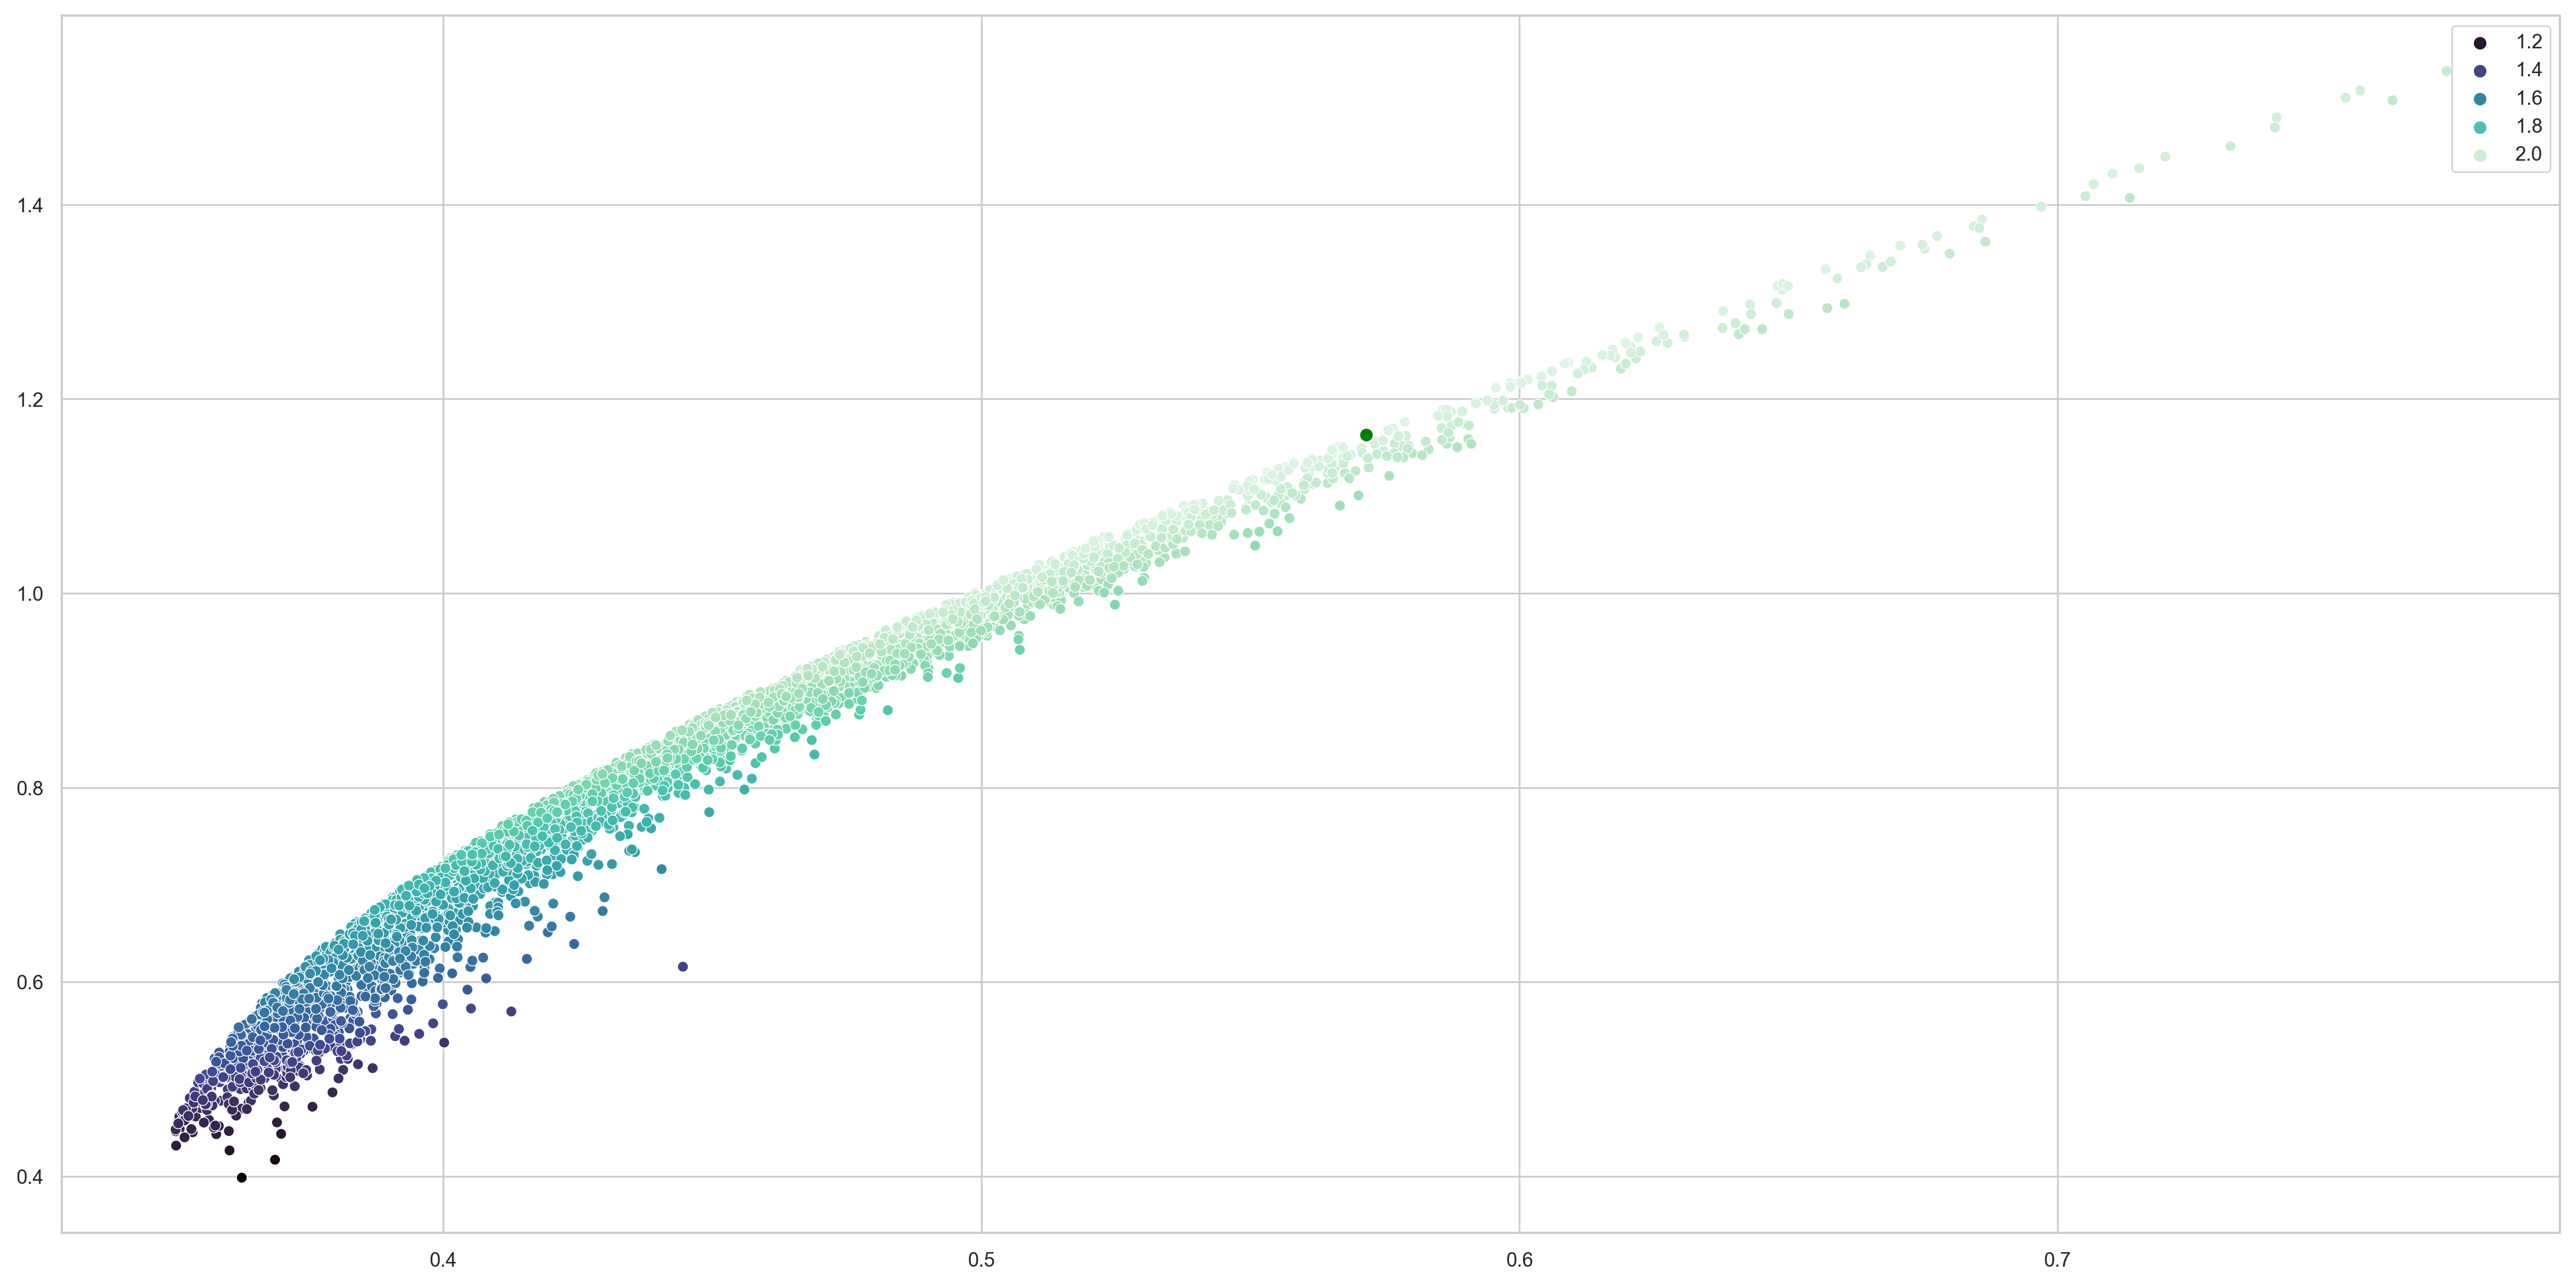

In [99]:
plt.rcParams['figure.dpi'] = 300
plt.figure(figsize=(20, 10))
sns.scatterplot(x=vol_arr, y=ret_arr, hue=sharpe_arr, palette='mako' )
plt.scatter(x=maxSrVol, y=maxSrRets,c='green') 
plt.savefig('EffFrontier.png',format='png')
plt.show()

In [15]:
import scipy
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
# the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

cons = ({'type':'eq', 'fun':check_sum})
bounds = ((0,1),(0,1),(0,1),(0,1))
init_guess = [0.25,0.25,0.25,0.25]

opt_results = scipy.optimize.minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
print(opt_results)

     fun: -1.6965908643289391
     jac: array([-0.00022097,  0.00012581,  0.11520301,  0.00033957])
 message: 'Optimization terminated successfully'
    nfev: 37
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([5.54979708e-01, 1.33332930e-01, 1.70265450e-17, 3.11687362e-01])


In [16]:
get_ret_vol_sr(opt_results.x)
frontier_y = np.linspace(0,1.5,200)
def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

frontier_x = []

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun':check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = scipy.optimize.minimize(minimize_volatility,init_guess,method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

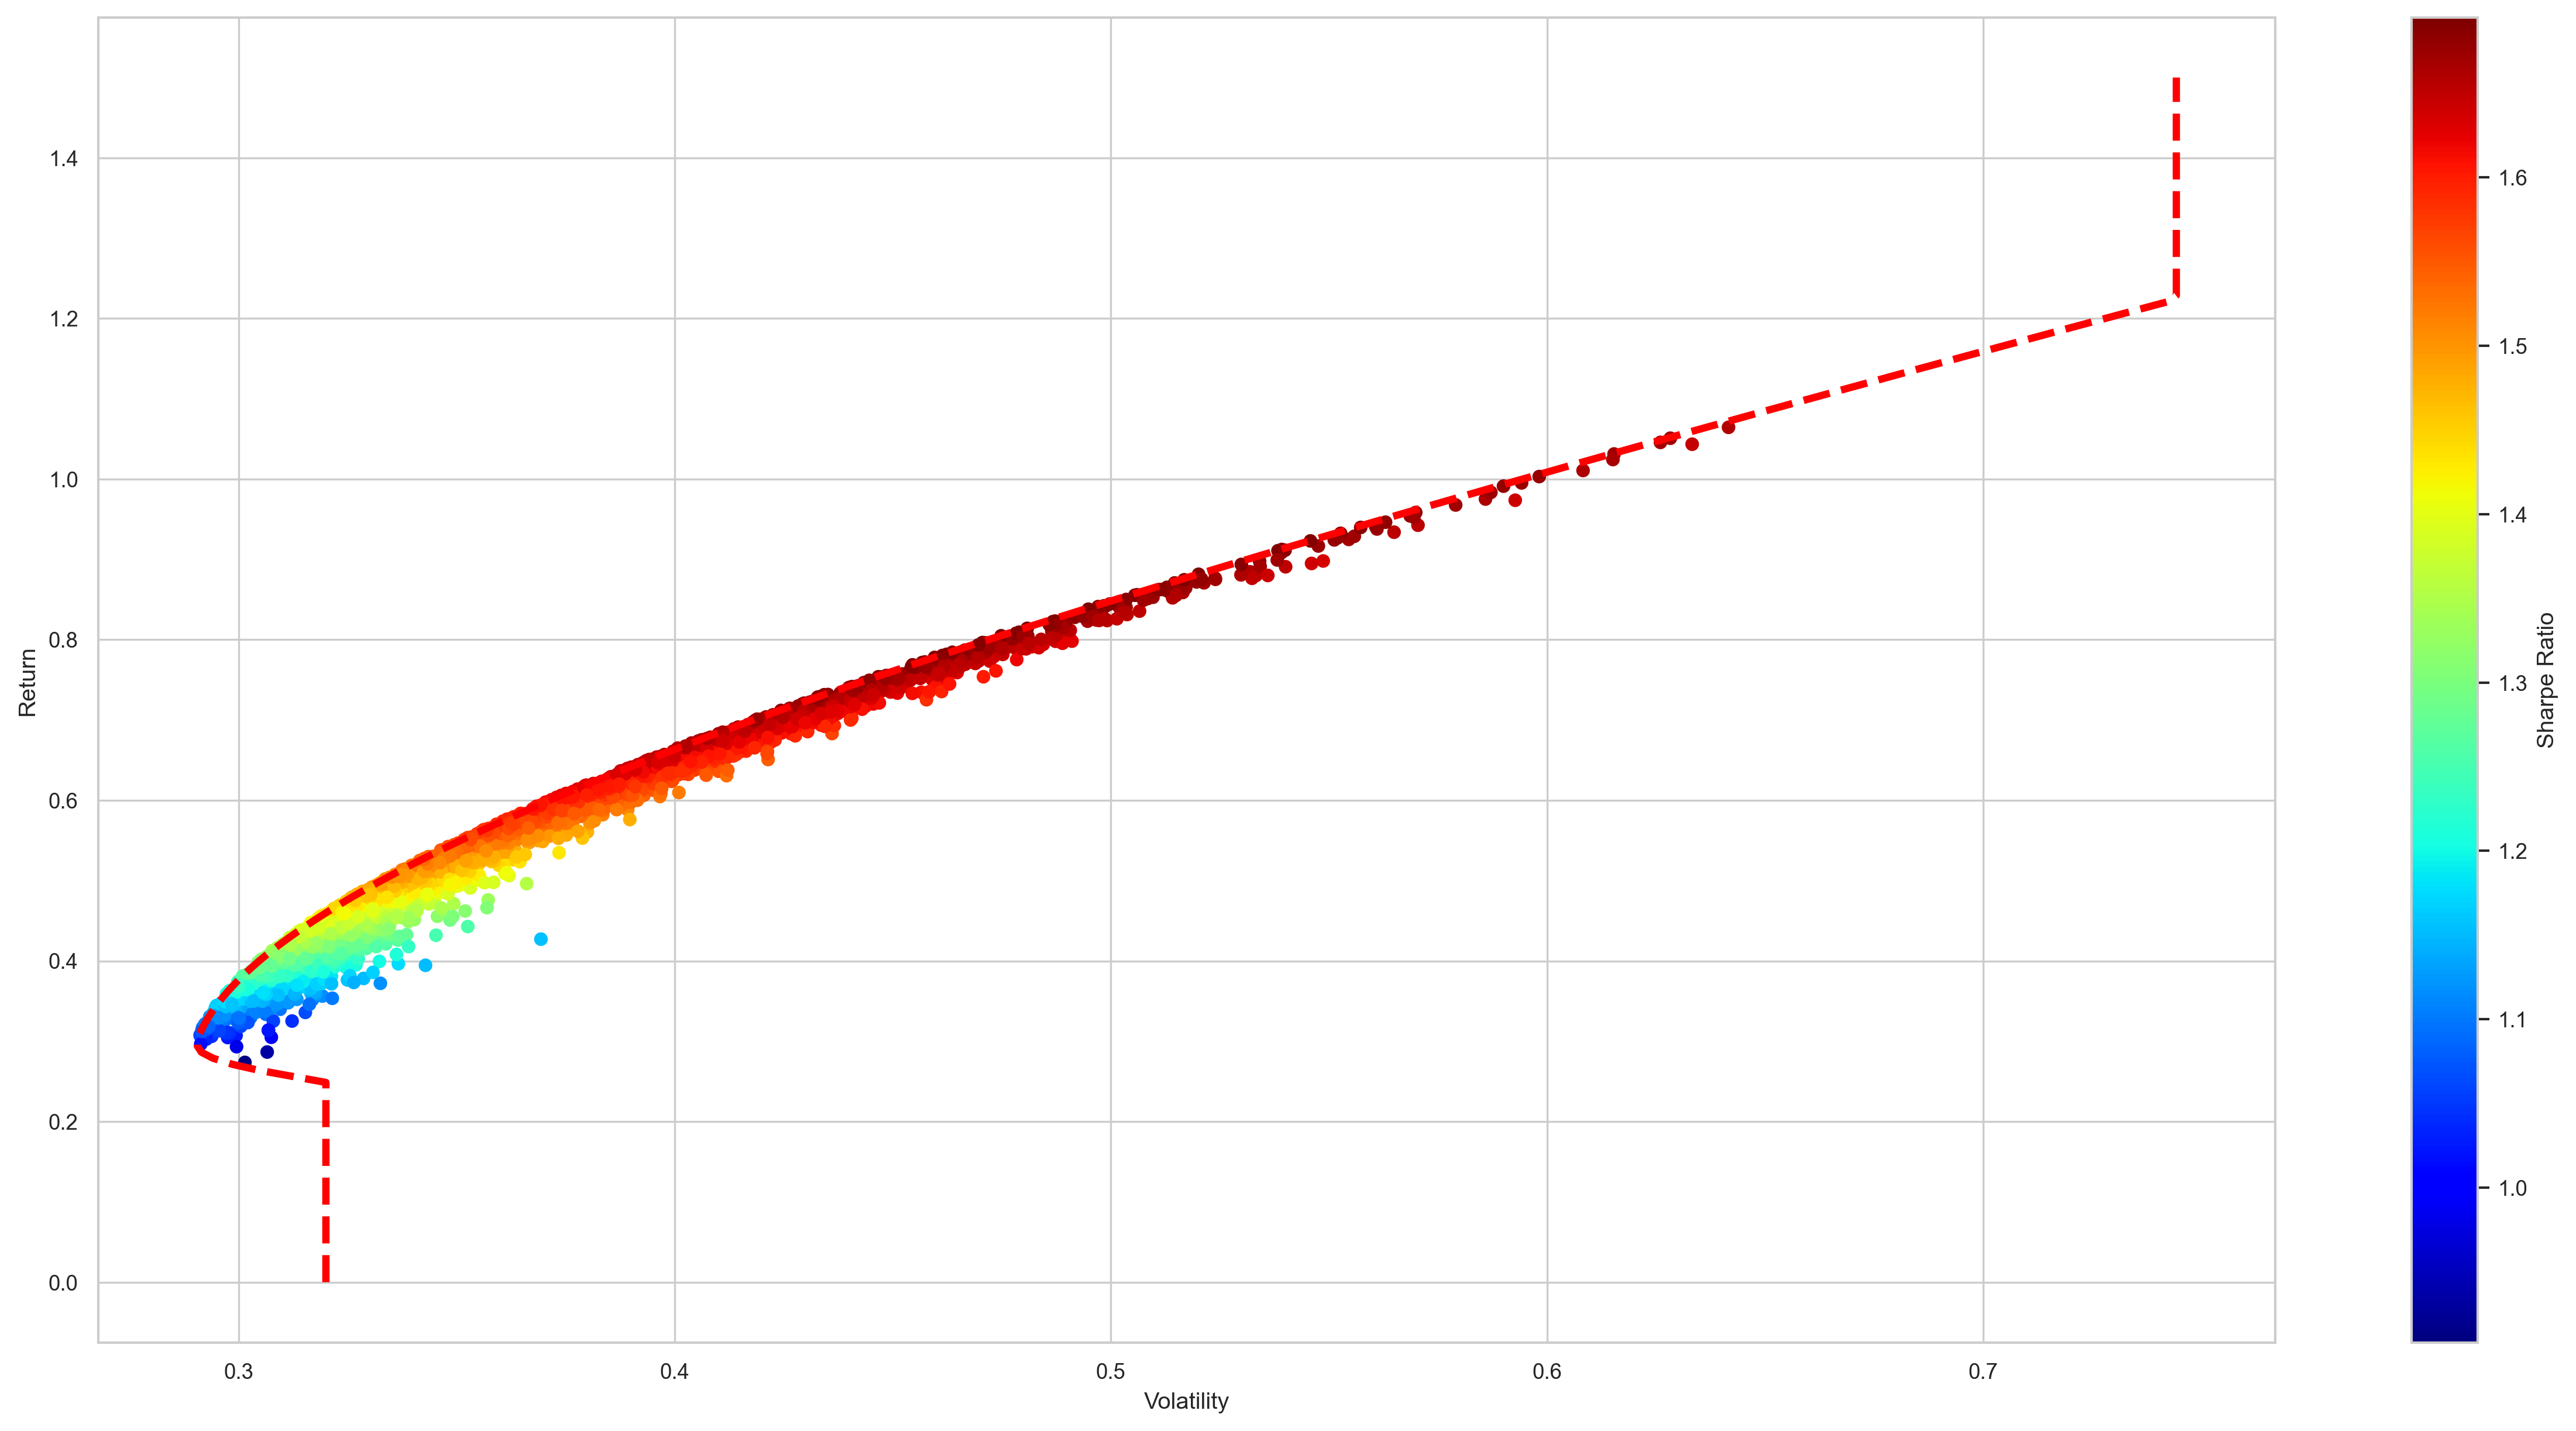

In [17]:
plt.figure(figsize=(20,10))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='jet')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x,frontier_y, 'r--', linewidth=3)
plt.show()

In [18]:
class Developer:
    def __init__(self):
        self.__seniority = 'Junior'
        self.skills = ''
        
    def display(self):
        print('Welcome to Turing with {seniority} developer with skill {skills}'.format(seniority = self.__seniority, skills=self.skills))
        
class nodeJS(Developer):
    
    def __init__(self):
        super().__init__()
        self.__seniority = 'Senior'
        self.skills = 'nodeJs'

c = nodeJS()
c.display()

Welcome to Turing with Junior developer with skill nodeJs
